# Foundations of Computational Economics #24

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Optimization through discretization (grid search)

<img src="_static/img/lecture.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/LyWRehkzIws](https://youtu.be/LyWRehkzIws)

Description: Grid search method and its use cases.

- Elementary technique of finding a maximum or minimum of a function  
- Main advantage: **robust**
  - works with *nasty* functions
  - derivative free
  - approximates **global** optimum  
- Main disadvantage: everything else
  - slow
  - imprecise
  - terrible in multivariate problems  
- Why used so much in economics?
  - objective function may be nasty
  - **as first step method** in multi-algorithms  

### Algorithm

$$
f(x) \longrightarrow \max
$$

1. Take a starting value $ x_0 $, define a region of search, i.e. $ I = (x_0-a,x_0+b) $  
1. Impose on $ I $ a discrete grid consisting of point $ x_i, i \in 1,\dots,n $  
1. Compute $ f(x_i) $ for all $ i $  
1. Return the maximum of $ f(x_i) $ as the result  

### Example

$$
\max_{x \in \mathbb{R}} f(x) = -x^4 + 2.5x^2 + x + 10
$$

First order condition leads to the critical points analytitcally:

$$
\begin{eqnarray}
f'(x)=-4x^3 + 5x +1 &=& 0 \\
-4x(x^2-1) + x+1 &=& 0 \\
(x+1)(-4x^2+4x+1) &=& 0 \\
\big(x+1\big)\big(x-\frac{1}{2}-\frac{1}{\sqrt{2}}\big)\big(x-\frac{1}{2}+\frac{1}{\sqrt{2}}\big) &=& 0
\end{eqnarray}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

f = lambda x: -x**4+2.5*x**2+x+10
df = lambda x: -4*x**3+5*x+1
d2f = lambda x: -12*x**2+5
critical_values = [-1.0,0.5 - 1/np.sqrt(2),0.5 + 1/np.sqrt(2)]  # analytic

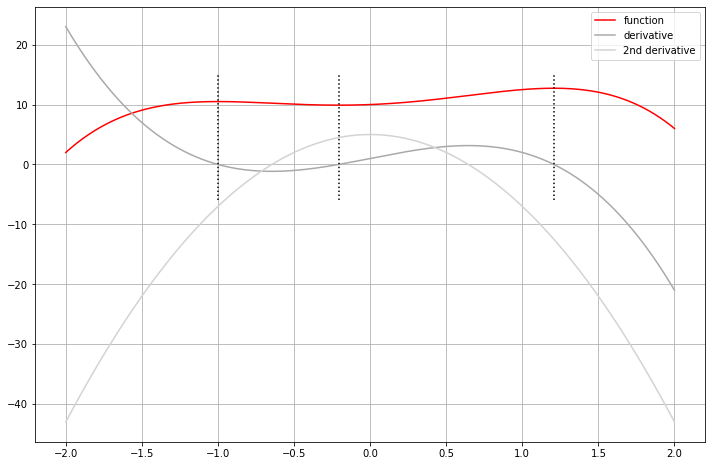

In [2]:
# make a plot of the function and its derivative
xd = np.linspace(-2,2,1000)
plt.plot(xd,f(xd),label='function',c='red')
plt.plot(xd,df(xd),label='derivative',c='darkgrey')
plt.plot(xd,d2f(xd),label='2nd derivative',c='lightgrey')
plt.grid(True)
plt.legend()
for cr in critical_values:
    plt.plot([cr,cr],[-6,15],c='k',linestyle=':')

In [3]:
import sys
sys.path.insert(1, './_static/include/')  # add path to the modules directory
import optim as o  # import our own optimization routines from last several lectures, see optim.py
help(o)

Help on module optim:

NAME
    optim

DESCRIPTION
    # Collection of simple optimization algorithms from the Computational Economics course
    #
    # by Fedor Iskhakov, 2020

FUNCTIONS
    bisection(f, a=0, b=1, tol=1e-06, maxiter=100, callback=None)
        Bisection method for solving equation f(x)=0
        on the interval [a,b], with given tolerance and number of iterations.
        Callback function is invoked at each iteration if given.
    
    newton(fun, grad, x0, tol=1e-06, maxiter=100, callback=None)
        Newton method for solving equation f(x)=0
        with given tolerance and number of iterations.
        Callback function is invoked at each iteration if given.
    
    newton2(fun, grad, x0, tol=1e-06, maxiter=100, callback=None)
        Newton method for solving equation f(x)=0, x is vector of 2 elements,
        with given tolerance and number of iterations.
        Callback function is invoked at each iteration if given.
    
    solve_sa(F, x0, tol=1e-06, maxi

In [4]:
# first, try to optimize with Newton
xs=[]
for x0 in [0.5,-0.5,1.0]:  # try different starting values
    xs.append( o.newton(df,d2f,x0))
print('Newton converged to: %r'%xs)

Newton converged to: [-1.0, -0.2071067809825758, 1.207106782385496]


In [5]:
# optimization through discretization
def grid_search(fun,bounds=(0,1),ngrid=10):
    '''Grid search between given bounds over given number of points'''
    grid = np.linspace(*bounds,ngrid)
    func = fun(grid)
    i = np.argmax(func)  # index of the element attaining maximum
    return grid[i]

b0,b1 = -2,2  # bounds of region of search
xs = grid_search(fun=f,bounds=(b0,b1),ngrid=10)
cr = critical_values[np.argmin(np.abs(critical_values-xs))]
print('Grid search returned x*=%1.5f (closest to critical point %1.5f, diff=%1.3e)'%(xs,cr,np.abs(xs-cr)))

Grid search returned x*=1.11111 (closest to critical point 1.20711, diff=9.600e-02)


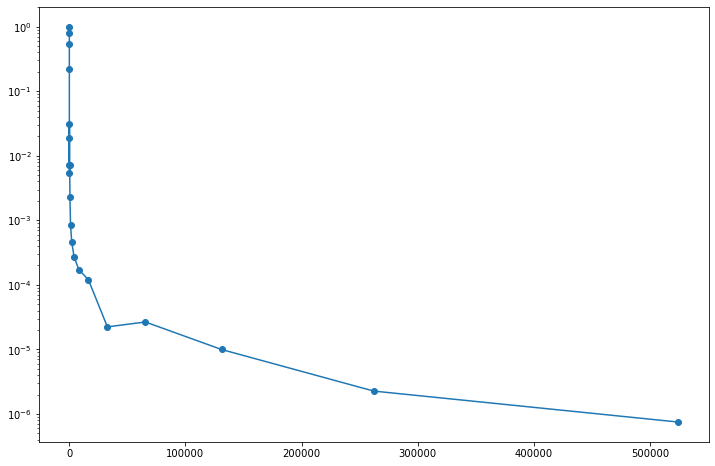

In [6]:
# check how fast accuracy increases with the number of grid points
data = {'n':[2**i for i in range(20)]}
data['err'] = np.empty(shape=len(data['n']))
for i,n in enumerate(data['n']):
    xs = grid_search(fun=f,bounds=(b0,b1),ngrid=n)
    cr = critical_values[np.argmin(np.abs(critical_values-xs))]
    data['err'][i] = np.abs(xs-cr)
plt.plot(data['n'],data['err'],marker='o')
plt.yscale('log')

#### More appropriate example

- grid search is slow and inaccurate  
- yet, it picks out the **global** optimum every time  
- more appropriate example:  


$$
f(x) = \begin{cases}
\exp(x+3) \text{ if } x \in (-\infty,-1] \\
10x+13 \text{ if } x \in (-1,-0.5] \\
75x^3 \text{ if } x \in (-0.5,0.5] \\
5 \text{ if } x \in (0.5,1.5] \\
\log(x-1.5) \text{ if } x \in (1.5,+\infty) \\
\end{cases}
$$

In [7]:
def f(x):
    x = np.asarray(x)
    if x.size==1:
        x = x[np.newaxis]  # to be able to process scalars in the same way
    res = np.empty(shape=x.shape)
    for i,ix in enumerate(x):
        if ix<=-1:
            res[i] = np.exp(ix+3)
        elif -1 < ix <= -0.5:
            res[i] = 10*ix+13
        elif -0.5 < ix <= 0.5:
            res[i] = 75*ix**3
        elif 0.5 < ix <= 1.5:
            res[i] = 5.0
        else:
            res[i] = np.log(ix-1.5)
    return res

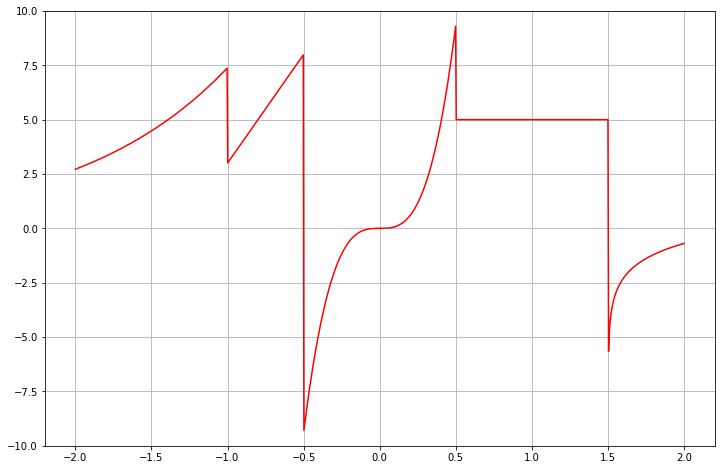

In [8]:
# plot
xd = np.linspace(-2,2,1000)
plt.plot(xd,f(xd),label='function',c='red')
plt.ylim((-10,10))
plt.grid(True)
plt.show()

### Why is this hard

*Any function with cases is usually nasty*

- kinks are non-differentiable points, trouble for Newton method  
- discontinuities are troubles for existence of either roots or maximum (think $ 1/x $ which illustrates both cases)  
- multiple local optima are troubles for non-global methods  
- regions where the function is completely flat will likely trigger the stopping criterion, trouble for convergence  


Discretization and grid search may be the only option!

### Examples of having to work with hard cases

- economic model may have discontinuities and/or kinks  
- estimation procedure may require working with piecewise flat and/or discontinuous functions  
- the function at hand may be costly to compute or unclear in nature (or subject of the study)  
- robustness checks over special parameters (categorical variables, assumptions, etc)  

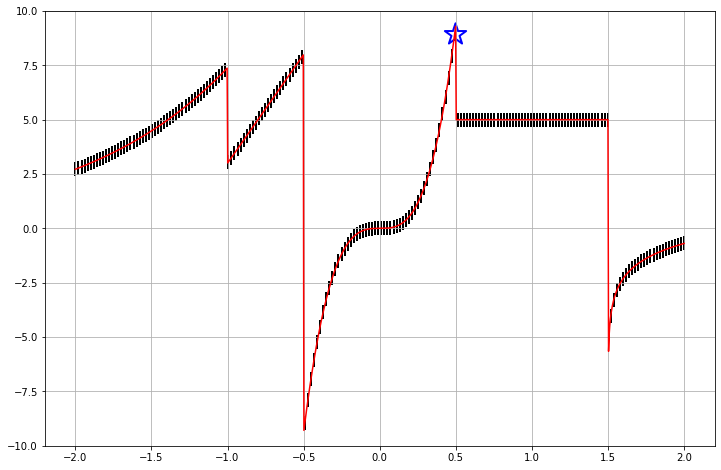

In [15]:
# bounds and the number of points on the grid
bounds, n = (-2,2), 200  # try 20 30 50 500
plt.plot(xd,f(xd),label='function',c='red')
plt.ylim((-10,10))
plt.grid(True)
# vizualize the grid
for x in np.linspace(*bounds,n):
    plt.scatter(x,f(x),s=200,marker='|',c='k',linewidth=2)
# solve
xs = grid_search(f,bounds,ngrid=n)
plt.scatter(xs,f(xs),s=500,marker='*',c='w',edgecolor='b',linewidth=2)  # mark the solution with a star
plt.show()

#### Poly-algorithms

- grid search is good choice for first stage of poly-algorithm
  - can robustly find promising region
  - small number of grid points for speed
  - accuracy not so important on first stage  
- more accurate algorithm starting at the best point found by grid search
  - with Newton sometimes referred to as *multi-starts*
  - hopefully, starting value already in the domain of attraction  
- or to start another grid search with smaller interval of search
  - *adaptive* grid search
  - pattern search (in multiple dimensions)  

#### Further learning resources

- Grid search in machine learning to tune *hyperparameters* (parameters of algorithm)
  [https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a](https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a)  